In [34]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Functions

In [35]:
def split_and_expand(row):
    """Split a string data accross coma
    """
    return pd.Series(row.split(','))   

def raw_data_to_dataframe(df_unseparated):
    """From a raw DataFrame returns a clean DataFrame separated on the coma.
    """ 

    columns_name = df_unseparated.columns[0].split(',')

    values = df_unseparated['Date,Open,High,Low,Close,Adj Close,Volume'].apply(split_and_expand).values

    return pd.DataFrame(values, columns=columns_name)

def df_of_aggregated_data(df_raw):
    """From Yahoo.fr export, returns a dataframe with the asset as ticker.
    """
    df_aggregated = pd.DataFrame()

    for indice in list(df_raw.keys()):
        df_raw[indice] = raw_data_to_dataframe(df_raw[indice])
        # Add the ticker on the dataframe
        df_raw[indice]['Ticker'] = [indice]*len(df_raw[indice])
        # concat all the data frame
        df_aggregated = pd.concat([df_aggregated, df_raw[indice]], axis=0)

    return df_aggregated.set_index('Date')


def convert_index_to_datetime(df):
    """
    Convert the index of a DataFrame from a string date format (YYYY-MM-DD) to datetime format.
    
    Parameters:
    - df: pandas DataFrame
    
    Returns:
    - pandas DataFrame with the index converted to datetime format
    """
    # Check if the DataFrame has an index
    if not isinstance(df.index, pd.DatetimeIndex):
        # Convert the index to datetime format
        df.index = pd.to_datetime(df.index)
    
    return df
    
def transform_df_with_str_values_into_float(df, columns_to_change):
    df[columns_to_change] = df[columns_to_change].apply(pd.to_numeric, errors='coerce')
    return df

def crop_dataframe(df, begin_date='1000-01-01', end_date='3000-01-01', all_dates=False):
    """
    Crop a DataFrame between two specified dates, keeping all occurrences of the dates if specified.

    Parameters:
    - df: pandas DataFrame
    - begin_date: str, format 'YYYY-MM-DD'
    - end_date: str, format 'YYYY-MM-DD'
    - all_dates: bool, if True, keep all data, regardless of the date interval (default: False)

    Returns:
    - pandas DataFrame cropped between begin_date and end_date (or the original DataFrame if all_dates is True)
    """
    # If all_dates is True, return the original DataFrame
    if all_dates:
        return df
    
    else:
        # Convert input dates to datetime format
        begin_date = pd.to_datetime(begin_date)
        end_date = pd.to_datetime(end_date)

        # Boolean indexing to keep all occurrences of dates within the specified interval
        cropped_df = df[(df.index >= begin_date) & (df.index <= end_date)]

        return cropped_df


# Functions for empirical moments
def get_mu_hat(gross_returns_table, end_date_for_the_empirical_sum):
    
    mu_hat_TIME_T = gross_returns_table.loc[:pd.to_datetime(end_date_for_the_empirical_sum)].mean(axis=0)

    return mu_hat_TIME_T.values

def get_omega_hat(gross_returns_table, end_date_for_the_empirical_sum):
    mu_hat = get_mu_hat(gross_returns_table=gross_returns_table, end_date_for_the_empirical_sum=end_date_for_the_empirical_sum)
    Y_minus_mu_hat = gross_returns_table - mu_hat

    omega_hat = np.zeros((len(Y_minus_mu_hat.columns),len(Y_minus_mu_hat.columns)))
    
    for date in Y_minus_mu_hat.index:
        Y_date_minus_mu_hat = Y_minus_mu_hat.loc[date].values.reshape(len(Y_minus_mu_hat.columns), 1)
        matrix_product_for_date = np.dot(Y_date_minus_mu_hat, Y_date_minus_mu_hat.T)
        omega_hat += matrix_product_for_date

    omega_hat /= len(omega_hat)
    
    return omega_hat

def create_stock_dataframe(tickers, start_date, end_date):
    data = {} 

    for ticker in tickers:
        # Pour télécharger les données boursières avec une fréquence mensuelle "1mo"
        stock_data = yf.download(ticker, start=start_date, end=end_date, interval='1mo')
        # Pour extraire et stocker les prix de clôture ajustés "Adj Close"
        data[ticker] = stock_data['Adj Close']
    df = pd.DataFrame(data)
    
    return df

# Download and clean data

In [36]:
# Créaiton du DataFrame
tickers = ['JPM', 'BP', 'AAPL','JNJ','MSFT','PG','V','HD','GE','PFE']
start_date = '2020-01-01'
end_date = '2023-12-01'
stock_df = create_stock_dataframe(tickers, start_date, end_date)
stock_df.head()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,JPM,BP,AAPL,JNJ,MSFT,PG,V,HD,GE,PFE
Date,,,,,,,,,,
2020-01-01,117.284691,29.154236,75.383652,133.691223,164.040131,112.892754,193.532990,207.160828,76.602280,30.266428
2020-02-01,103.546028,25.248714,66.579010,120.768417,156.118988,103.183998,176.793259,197.842682,66.942421,27.439215
2020-03-01,80.288078,20.020252,62.081352,118.510925,152.390457,100.240578,156.944260,169.570389,48.853172,26.798805
2020-04-01,85.398064,19.535955,71.727173,135.601151,173.165253,107.412338,174.088089,200.985748,41.880535,31.495165
2020-05-01,87.682091,18.994202,77.620598,134.435272,177.068985,106.339813,190.179947,227.179840,40.464001,31.355593


# Plot index evolution

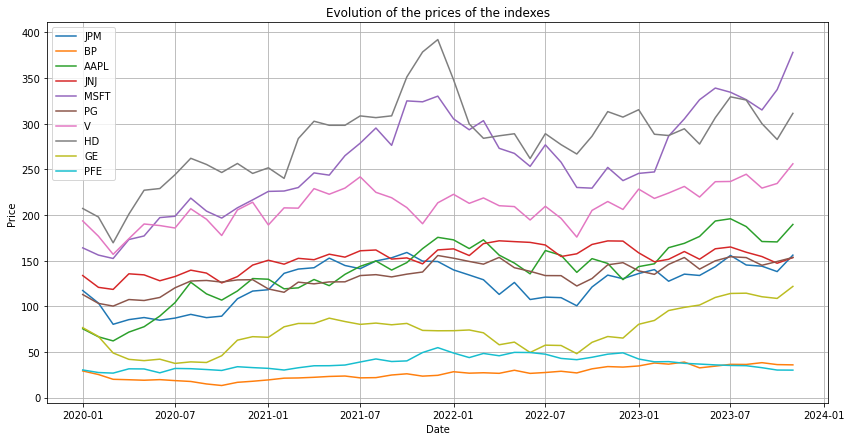

In [37]:
plt.figure(figsize=(14, 7))
for c in stock_df.columns.values:
    plt.plot(stock_df.index, stock_df[c], label=c)
plt.legend()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Evolution of the prices of the indexes')
plt.show()

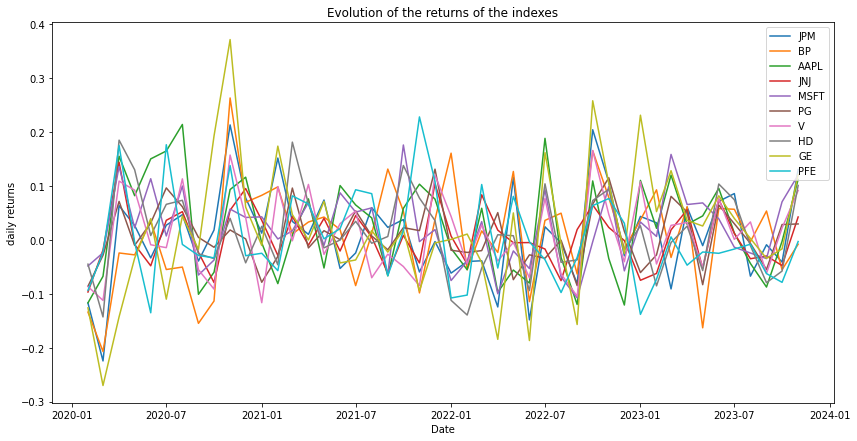

In [38]:
returns = stock_df.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], label=c)
plt.legend()
plt.ylabel('daily returns')
plt.xlabel('Date')
plt.title('Evolution of the returns of the indexes')
plt.show()

# Efficient frontier representation

## Empirical moments

In [39]:
TIME_T = end_date
Y_full=(returns+1).iloc[1:]
Y_full.head()

,JPM,BP,AAPL,JNJ,MSFT,PG,V,HD,GE,PFE
Date,,,,,,,,,,
2020-02-01,0.882861,0.866039,0.883202,0.903338,0.951712,0.914000,0.913505,0.955020,0.873896,0.906589
2020-03-01,0.775385,0.792922,0.932446,0.981307,0.976117,0.971474,0.887728,0.857097,0.729779,0.976661
2020-04-01,1.063646,0.975810,1.155374,1.144208,1.136326,1.071545,1.109235,1.185264,0.857274,1.175245
2020-05-01,1.026746,0.972269,1.082164,0.991402,1.022543,0.990015,1.092435,1.130328,0.966177,0.995568
2020-06-01,0.966602,1.034877,1.150492,0.951966,1.113652,1.031487,0.991054,1.008169,1.039574,0.864778


In [40]:
mu_hat = get_mu_hat(gross_returns_table=Y_full, end_date_for_the_empirical_sum=TIME_T)
mu_hat

array([1.00988265, 1.00874352, 1.0242488 , 1.00437436, 1.02055395,
       1.00810331, 1.00886581, 1.01180034, 1.01699406, 1.00316221])

In [41]:
omega_hat =get_omega_hat(gross_returns_table=Y_full, end_date_for_the_empirical_sum=TIME_T)
omega_hat

array([[ 0.03348841,  0.02470383,  0.0123511 ,  0.00719608,  0.00865843,
         0.00498756,  0.01731062,  0.01480435,  0.03544068,  0.00791541],
       [ 0.02470383,  0.03901719,  0.00642288,  0.00579646,  0.00316401,
         0.00250848,  0.01534343,  0.00680955,  0.02985803,  0.00046119],
       [ 0.0123511 ,  0.00642288,  0.03757131,  0.00895591,  0.02073525,
         0.00915008,  0.01864512,  0.01777365,  0.01611688,  0.01162869],
       [ 0.00719608,  0.00579646,  0.00895591,  0.01281994,  0.00546164,
         0.00735605,  0.00868537,  0.00847865,  0.0008544 ,  0.01101159],
       [ 0.00865843,  0.00316401,  0.02073525,  0.00546164,  0.02108837,
         0.00604586,  0.01024512,  0.01238448,  0.01211024,  0.00647252],
       [ 0.00498756,  0.00250848,  0.00915008,  0.00735605,  0.00604586,
         0.01302702,  0.0079995 ,  0.00994929,  0.00333546,  0.00922504],
       [ 0.01731062,  0.01534343,  0.01864512,  0.00868537,  0.01024512,
         0.0079995 ,  0.02575159,  0.0125221 

In [42]:
def objective(weights, gamma, returns, cov_matrix):
    """_summary_

    Args:
        weights (_type_): Column vector of the weights
        gamma (_type_): Inverse of the risk aversion parameter
        returns (_type_):  Column vector of the expected returns
        cov_matrix (_type_): Matrix of covariance

    Returns:
        _type_: _description_
    """
    x_star = 1/2 * weights.T @ cov_matrix @ weights - gamma * weights.T @ returns
    return x_star


def constraint_fully_invested(x_weights):
    return sum(x_weights) - 1



# Inputs

In [43]:
# propostion of risk-free asset in the portfolio
ALPHA = 0.1
# risk-free rate
RISK_FREE_RATE = 0.95
# Set gamma values
GAMMA_VALUES = np.linspace(-5, 5, 100)  # Inverse of the risk aversion parameter

In [44]:
# Sustainalytics scores [APPL, BP, JPM] -> the smaller, the better
SUSTAINALYTICS_SCORES = [17.2, 34.6, 29.3, 24, 15, 29, 17, 13, 41, 25]
# Score max
MAX_SCORE = 25

N_ASSETS=10

# Best in class method

## Identification of the top 80% environmentally sustainable assets.

In [45]:
sub_scores=pd.DataFrame(SUSTAINALYTICS_SCORES,columns=['ESG_SCORE'],index=Y_full.columns)
sub_scores=sub_scores.sort_values(by='ESG_SCORE')

rows_to_drop = int(0.2 * len(sub_scores))

# Drop the last 20% of rows
sub_scores_dropped = sub_scores.iloc[:-rows_to_drop]

Y_full_dropped=Y_full[sub_scores_dropped.index]

N_ASSETS_dropped=len(Y_full_dropped.columns)
SUSTAINALYTICS_SCORE_DROPPED=list(sub_scores_dropped['ESG_SCORE'])
SUSTAINALYTICS_SCORE_DROPPED

[13.0, 15.0, 17.0, 17.2, 24.0, 25.0, 29.0, 29.3]

## Efficient frontier for this subset of assets

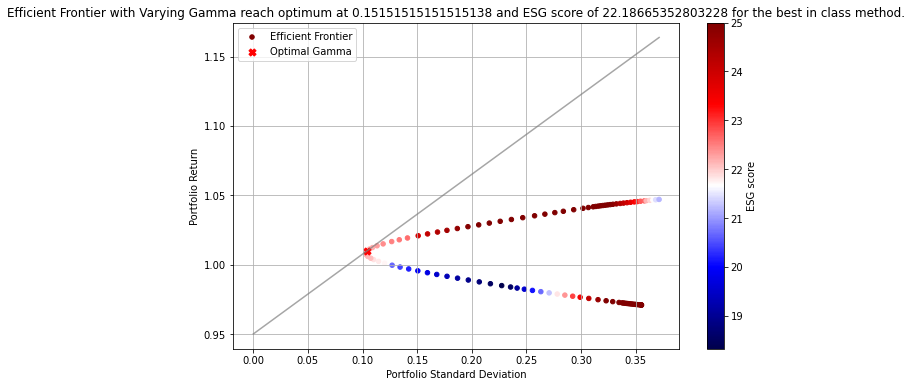

In [46]:
def constraint_ESG_max_dropped(x_weights):
    return - (np.dot(SUSTAINALYTICS_SCORE_DROPPED[:8], x_weights) - MAX_SCORE) # minus for having inferior or equal in the constraint

def plot_efficient_frontier_dropped(mean_returns, cov_matrix, constraints, bounds, gamma_values, risk_free_rate, alpha, color_bar='gamma', abscisse_0=True):
    initial_weights = np.ones(len(mean_returns)) / len(mean_returns)

    weights_gamma = []
    mu_x, mu_y = [], []
    sigma_x, sigma_y = [], []
    objective_values = []
    score_esg = []

    for gamma_val in gamma_values:
        #print(len(initial_weights),gamma_val,len(mean_returns),len(cov_matrix),len(constraints),len(bounds))
        result = minimize(objective, initial_weights, args=(gamma_val, mean_returns, cov_matrix),
                          constraints=constraints, bounds=bounds)
        weights_gamma.append(list(result.x))

        mu = np.dot(mean_returns, result.x)
        mu_x.append(mu)
        mu_y.append((1 - alpha) * risk_free_rate + alpha * mu)

        sigma = np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x)))
        sigma_x.append(sigma)
        sigma_y.append(alpha * sigma)

        objective_values.append(-result.fun)

        score_esg.append(np.dot(SUSTAINALYTICS_SCORE_DROPPED, list(result.x)))

    tangente_theta = [(a - risk_free_rate) / b for a, b in zip(mu_y, sigma_y)]
    tangente_index = np.argmax(tangente_theta)
    gamma_tangent = gamma_values[tangente_index]
    mu_x_tangent = mu_x[tangente_index]
    sigma_x_tangent = sigma_x[tangente_index]
    score_esg_tangent = score_esg[tangente_index]

    # Plot the efficient frontier
    plt.figure(figsize=(10, 6))

    if color_bar == 'gamma':
        plt.scatter(sigma_x, mu_x, s=20, c=gamma_values, cmap='viridis', label='Efficient Frontier')
        plt.colorbar(label='Gamma Values')
    elif color_bar == 'esg':
        plt.scatter(sigma_x, mu_x, s=20, c=score_esg, cmap='seismic', label='Efficient Frontier')
        plt.colorbar(label='ESG score')
 
    plt.scatter(x=sigma_x_tangent, y=mu_x_tangent, marker='X', s=50, c='r', label='Optimal Gamma')
    
    # Plot the tangent portfolio
    abscisses = [min(sigma_x) * 0.98, max(sigma_x)]
    ordonnées = [risk_free_rate + (mu_x_tangent - risk_free_rate) / sigma_x_tangent * min(sigma_x) * 0.98,
                 risk_free_rate + (mu_x_tangent - risk_free_rate) / sigma_x_tangent * max(sigma_x)]
    
    if abscisse_0:
        # Include ordinate of x=0
        abscisses.insert(0, 0)
        ordonnées.insert(0, RISK_FREE_RATE)

        
    plt.plot(abscisses, ordonnées, alpha=0.7, c='grey')

    plt.title(f'Efficient Frontier with Varying Gamma reach optimum at {gamma_tangent} and ESG score of {score_esg_tangent} for the best in class method.')
    plt.xlabel('Portfolio Standard Deviation')
    plt.ylabel('Portfolio Return')
    plt.legend()
    plt.grid(True)
    plt.show()



# Calculate the mean returns and covariance matrix
mean_returns_dropped = get_mu_hat(gross_returns_table=Y_full_dropped, end_date_for_the_empirical_sum=TIME_T)
cov_matrix_dropped = get_omega_hat(gross_returns_table=Y_full_dropped, end_date_for_the_empirical_sum=TIME_T)

# Define constraintsx
constraints_dropped = ({'type': 'eq', 'fun': constraint_fully_invested}, # fully invested portfolio
               {'type': 'ineq', 'fun': constraint_ESG_max_dropped}) # ESG score inferior to a constant
bounds_dropped = [(-1, 1)] * N_ASSETS_dropped # possession of asset in [-1, 1]


# Choose color bar type: 'gamma' or 'esg'
plot_efficient_frontier_dropped(mean_returns=mean_returns_dropped,
                        cov_matrix=cov_matrix_dropped,
                        constraints = constraints_dropped,
                        bounds=bounds_dropped,
                        gamma_values=GAMMA_VALUES,
                        risk_free_rate=RISK_FREE_RATE,
                        alpha=ALPHA,
                        color_bar='esg')

It can be observed that the tangent portfolio attains a lower ESG score compared to the traditional method. However, the standard deviation for this new tangent portfolio is higher than that of the original one, despite having an equivalent portfolio return.

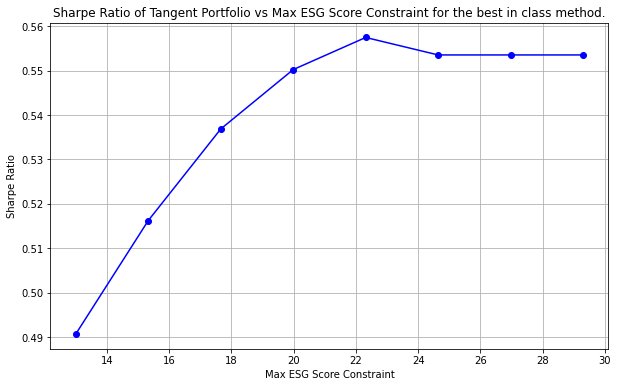

In [47]:
MAX_SCORES_dropped = np.linspace(np.min(SUSTAINALYTICS_SCORE_DROPPED), np.max(SUSTAINALYTICS_SCORE_DROPPED), 8)

def constraint_ESG_max_dropped(x_weights,MAX_SCORES_dropped):
    return - (np.dot(SUSTAINALYTICS_SCORE_DROPPED, x_weights) - MAX_SCORES_dropped) # minus for having inferior or equal in the constraint


def plot_sharpe_ratio_vs_max_score(mean_returns, cov_matrix, bounds, gamma_values, risk_free_rate, alpha, max_scores):
    initial_weights = np.ones(len(mean_returns)) / len(mean_returns)

    sharpe_ratios = []

    for max_score in max_scores:
        constraints = [
            {'type': 'eq', 'fun': constraint_fully_invested},  # fully invested portfolio
            {'type': 'ineq', 'fun': lambda x, max_score=max_score: constraint_ESG_max_dropped(x, max_score)}
        ]
        objective_values = []
        for gamma_val in gamma_values:
            result = minimize(objective, initial_weights, args=(gamma_val, mean_returns, cov_matrix),
                              constraints=constraints, bounds=bounds)
            objective_values.append(-result.fun)

        tangente_theta = [(a - risk_free_rate) / b for a, b in zip(objective_values, gamma_values)]
        tangente_index = np.argmax(tangente_theta)
        gamma_tangent = gamma_values[tangente_index]

        # Calcul du Sharpe ratio du portefeuille tangent
        weights_tangent = minimize(objective, initial_weights, args=(gamma_tangent, mean_returns, cov_matrix),
                                   constraints=constraints, bounds=bounds).x
        mu_tangent = np.dot(mean_returns, weights_tangent)
        sigma_tangent = np.sqrt(np.dot(weights_tangent.T, np.dot(cov_matrix, weights_tangent)))
        sharpe_ratio = (mu_tangent - risk_free_rate) / sigma_tangent

        sharpe_ratios.append(sharpe_ratio)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(max_scores, sharpe_ratios, marker='o', linestyle='-', color='b')
    plt.title('Sharpe Ratio of Tangent Portfolio vs Max ESG Score Constraint for the best in class method.')
    plt.xlabel('Max ESG Score Constraint')
    plt.ylabel('Sharpe Ratio')
    plt.grid(True)
    plt.show()


plot_sharpe_ratio_vs_max_score(mean_returns_dropped, cov_matrix_dropped, bounds_dropped, GAMMA_VALUES, RISK_FREE_RATE, ALPHA, MAX_SCORES_dropped)


It can be noted that the Sharpe ratio behaves similarly to that in traditional optimization, but it does not exceed 0.56 (in contrast to 0.64 in the traditional approach)

# Short Brown Assets

## Change of the bounds for the brown asset.

(-1,1) --> (-1,0) means we only short them

In [48]:
sub_scores=pd.DataFrame(SUSTAINALYTICS_SCORES,columns=['ESG_SCORE'],index=Y_full.columns)
sub_scores=sub_scores.T

columns_bs_loc=[sub_scores.columns.get_loc(column) for column in sub_scores.columns if sub_scores[column][0]>25]

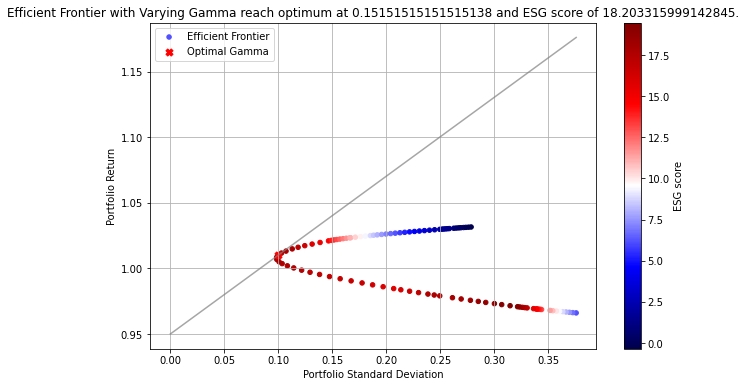

In [49]:
def constraint_ESG_max(x_weights):
    return - (np.dot(SUSTAINALYTICS_SCORES, x_weights) - MAX_SCORE) # minus for having inferior or equal in the constraint

def plot_efficient_frontier_dropped(mean_returns, cov_matrix, constraints, bounds, gamma_values, risk_free_rate, alpha, color_bar='gamma', abscisse_0=True):
    initial_weights = np.ones(len(mean_returns)) / len(mean_returns)

    weights_gamma = []
    mu_x, mu_y = [], []
    sigma_x, sigma_y = [], []
    objective_values = []
    score_esg = []

    for gamma_val in gamma_values:
        #print(len(initial_weights),gamma_val,len(mean_returns),len(cov_matrix),len(constraints),len(bounds))
        result = minimize(objective, initial_weights, args=(gamma_val, mean_returns, cov_matrix),
                          constraints=constraints, bounds=bounds)
        weights_gamma.append(list(result.x))

        mu = np.dot(mean_returns, result.x)
        mu_x.append(mu)
        mu_y.append((1 - alpha) * risk_free_rate + alpha * mu)

        sigma = np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x)))
        sigma_x.append(sigma)
        sigma_y.append(alpha * sigma)

        objective_values.append(-result.fun)

        score_esg.append(np.dot(SUSTAINALYTICS_SCORES, list(result.x)))

    tangente_theta = [(a - risk_free_rate) / b for a, b in zip(mu_y, sigma_y)]
    tangente_index = np.argmax(tangente_theta)
    gamma_tangent = gamma_values[tangente_index]
    mu_x_tangent = mu_x[tangente_index]
    sigma_x_tangent = sigma_x[tangente_index]
    score_esg_tangent = score_esg[tangente_index]

    # Plot the efficient frontier
    plt.figure(figsize=(10, 6))

    if color_bar == 'gamma':
        plt.scatter(sigma_x, mu_x, s=20, c=gamma_values, cmap='viridis', label='Efficient Frontier')
        plt.colorbar(label='Gamma Values')
    elif color_bar == 'esg':
        plt.scatter(sigma_x, mu_x, s=20, c=score_esg, cmap='seismic', label='Efficient Frontier')
        plt.colorbar(label='ESG score')
 
    plt.scatter(x=sigma_x_tangent, y=mu_x_tangent, marker='X', s=50, c='r', label='Optimal Gamma')
    
    # Plot the tangent portfolio
    abscisses = [min(sigma_x) * 0.98, max(sigma_x)]
    ordonnées = [risk_free_rate + (mu_x_tangent - risk_free_rate) / sigma_x_tangent * min(sigma_x) * 0.98,
                 risk_free_rate + (mu_x_tangent - risk_free_rate) / sigma_x_tangent * max(sigma_x)]
    
    if abscisse_0:
        # Include ordinate of x=0
        abscisses.insert(0, 0)
        ordonnées.insert(0, RISK_FREE_RATE)

        
    plt.plot(abscisses, ordonnées, alpha=0.7, c='grey')

    plt.title(f'Efficient Frontier with Varying Gamma reach optimum at {gamma_tangent} and ESG score of {score_esg_tangent}.')
    plt.xlabel('Portfolio Standard Deviation')
    plt.ylabel('Portfolio Return')
    plt.legend()
    plt.grid(True)
    plt.show()



# Calculate the mean returns and covariance matrix
mean_returns_bs= get_mu_hat(gross_returns_table=Y_full, end_date_for_the_empirical_sum=TIME_T)
cov_matrix_bs= get_omega_hat(gross_returns_table=Y_full, end_date_for_the_empirical_sum=TIME_T)

# Define constraintsx
constraints = ({'type': 'eq', 'fun': constraint_fully_invested}, # fully invested portfolio
               {'type': 'ineq', 'fun': constraint_ESG_max}) # ESG score inferior to a constant
bounds_bs = [(-1, 0) if i in columns_bs_loc else (-1, 1) for i in range(N_ASSETS)] #(-1,0) for the brown assets and (-1,1) for the remaining ones


# Choose color bar type: 'gamma' or 'esg'
plot_efficient_frontier_dropped(mean_returns=mean_returns_bs,
                        cov_matrix=cov_matrix_bs,
                        constraints = constraints,
                        bounds=bounds_bs,
                        gamma_values=GAMMA_VALUES,
                        risk_free_rate=RISK_FREE_RATE,
                        alpha=ALPHA,
                        color_bar='esg')

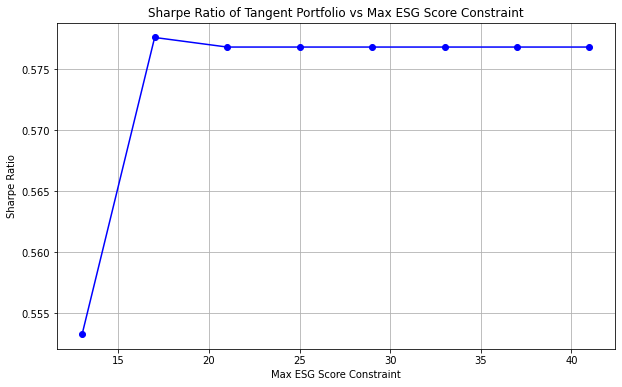

In [50]:
MAX_SCORES = np.linspace(np.min(SUSTAINALYTICS_SCORES), np.max(SUSTAINALYTICS_SCORES), 8)

def constraint_ESG_max(x_weights,MAX_SCORES_dropped):
    return - (np.dot(SUSTAINALYTICS_SCORES, x_weights) - MAX_SCORES_dropped) # minus for having inferior or equal in the constraint


def plot_sharpe_ratio_vs_max_score(mean_returns, cov_matrix, bounds, gamma_values, risk_free_rate, alpha, max_scores):
    initial_weights = np.ones(len(mean_returns)) / len(mean_returns)

    sharpe_ratios = []

    for max_score in max_scores:
        constraints = [
            {'type': 'eq', 'fun': constraint_fully_invested},  # fully invested portfolio
            {'type': 'ineq', 'fun': lambda x, max_score=max_score: constraint_ESG_max(x, max_score)}
        ]
        objective_values = []
        for gamma_val in gamma_values:
            result = minimize(objective, initial_weights, args=(gamma_val, mean_returns, cov_matrix),
                              constraints=constraints, bounds=bounds)
            objective_values.append(-result.fun)

        tangente_theta = [(a - risk_free_rate) / b for a, b in zip(objective_values, gamma_values)]
        tangente_index = np.argmax(tangente_theta)
        gamma_tangent = gamma_values[tangente_index]

        # Calcul du Sharpe ratio du portefeuille tangent
        weights_tangent = minimize(objective, initial_weights, args=(gamma_tangent, mean_returns, cov_matrix),
                                   constraints=constraints, bounds=bounds).x
        mu_tangent = np.dot(mean_returns, weights_tangent)
        sigma_tangent = np.sqrt(np.dot(weights_tangent.T, np.dot(cov_matrix, weights_tangent)))
        sharpe_ratio = (mu_tangent - risk_free_rate) / sigma_tangent

        sharpe_ratios.append(sharpe_ratio)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(max_scores, sharpe_ratios, marker='o', linestyle='-', color='b')
    plt.title('Sharpe Ratio of Tangent Portfolio vs Max ESG Score Constraint')
    plt.xlabel('Max ESG Score Constraint')
    plt.ylabel('Sharpe Ratio')
    plt.grid(True)

    plt.show()


plot_sharpe_ratio_vs_max_score(mean_returns_bs, cov_matrix_bs, bounds_bs, GAMMA_VALUES, RISK_FREE_RATE, ALPHA, MAX_SCORES)
